In [54]:
import numpy as np
import math
import pandas as pd
import hashlib, random
from sklearn.mixture import GaussianMixture
import copy
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import jsonpickle
from random import shuffle
from collections import defaultdict
import os, json
from datetime import datetime
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random, json
from tqdm import trange, tqdm
from operator import itemgetter
from analyzer import *
import query_gen

sns.set(style='ticks', palette='coolwarm') #this overwrites matplotlib setting so make it run first 

# def set_font():
import matplotlib
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html

font = {'weight' : 'bold',
#         'size'   : 20,
       'family': 'Linux Libertine O'}
matplotlib.rc('font', **font)

In [55]:
!hostname

vulture


In [56]:


def restore_obj(path):
    try:
        with open(path) as f:
            s = f.read()
            data = jsonpickle.decode(s, keys = True)
            print("Loaded %s" % path)
            return data
    except Exception as e:
        print("failed to restore", path, e)
        return None

def load_and_merge(config):
    # load all the files and merge them together because we have different files representing different partition type.
    baseline_perf = defaultdict(dict)
    queries = {}
#     print(config)
    for name, path in config.items():
        path = '/local/xi/VarAcc/src/cache/'+path
        if 'json' in path:
            data = json.load(open(path))
        else:
            data = restore_obj(path)
        if 'GT' in name:
            queries[name[-1]] = data
        else:
            k = name.split('-')[0]
            for base, perf in data.items():
                baseline_perf[k][base] = perf
    return queries, baseline_perf


In [77]:
def plot_percentile_1_columns(
                 query_results,
                 metric_id, percentiles = [95, 100],    
                 ymin = None, show_avg = False, x_label = None, title = None,
                 log_scale = True, y_label=None, show_p = True,
                 plot_hidden = True, fname = None
                ):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    markers = ['o', '^', '*', 'v', 'd', 'X', 'P', 'p', '4']
    linestyles= [':', '-.', '--', '-']
    fig, axs = plt.subplots(1, len(query_results), figsize=(12, 6))
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    width = 0.6
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    
#     formatter = ScalarFormatter()
#     formatter.set_scientific(False)
    for n_df in range(len(query_results)):
        query_type = list(query_results.keys())[n_df]
        results = query_results[query_type]
        x_labels = [x for x in results.keys()]

        metric = list(results[x_labels[0]].keys())[metric_id] #metric

        baselines = list(results[x_labels[0]][metric].keys())

        #this is to help scale yxis better
        baseline_perf = defaultdict(list)

        line_count = -1
        style = defaultdict(dict)
        for baseline in baselines:
            line_count+=1
            for k in x_labels:
                marker_count = 0
                data = results[k][metric][baseline]
                legend = ''
                if percentiles is None:
                    # failure rate
                    legend = baseline
                    log_scale = False
                    baseline_perf[legend].append(sum(data)/len(data))
                    marker_count += 1
                else:
                    if show_avg is True:
                        if show_p:
                            legend = 'AVG-'
                            
                        legend += baseline
                        baseline_perf[legend].append(np.mean(data))
                        marker_count += 1
                        style[legend]['l'] = line_count
                        style[legend]['m'] = marker_count
                    for p in percentiles:
                        if show_p:
                            legend = 'P' + str(p) +'-' 
                            if p == 50:
                                legend = 'Median-'
                                
                        legend += baseline
                        baseline_perf[legend].append(np.percentile(data, p))
                        marker_count += 1
                        style[legend]['l'] = line_count
                        style[legend]['m'] = marker_count
                

        if len(query_results) > 1:
            ax = axs[n_df]
        else:
            ax = axs
        
        idx = 0
        for legend, perf in baseline_perf.items():
            legend = legend.replace("PASS", "-PASS")
            legend = legend.replace("AQP++", "Simplified-AQP++")
            color = our_color if ('DP' in legend or 'PASS' in legend) else baseline_color
            ls = linestyles[1] if not ('DP' in legend or 'PASS' in legend) else '-'
#             ax.plot(perf, label=legend, marker=markers[style[legend]['m']], linestyle=ls, c = color, mfc = 'black', lw = 3, ms = 15)
            ax.plot(perf, label=legend, marker=markers[idx],  c = color, mfc = 'black', lw = 3, ms = 15)
            idx += 1
            
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_xticklabels(x_labels, fontsize=font_size-5)
    
        ax.legend(fontsize=20)
        
        y_label = metric if y_label is None else y_label
        if n_df == 0:
            ax.set_ylabel(y_label, fontdict = xfont)
        if title is not None:
            ax.set_title(title, fontdict=xfont)
        else:
            ax.set_title(query_type, fontdict=xfont)
        ax.set_xlabel(x_label, fontdict = xfont)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if ymin is not None:
            ax.set_ylim(ymin=ymin)
        if log_scale is True:
            ax.set_yscale("log")

    fig.tight_layout()
    plt.show()
    if fname:
        fig.savefig("figures/"+fname+".pdf", bbox_inches='tight')
        
def plot_percentile_2_columns(
                 query_results,
                 metric_ids, percentiles = [95, 100],    
                 ymin = None, show_avg = False, x_label = None, title = None,
                 log_scale = True, y_labels=None, show_p = True,
                 plot_hidden = True, fname = None
                ):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    markers = ['o', '^', '*', 'v', 'd', 'X', 'P', 'p', '4']
    linestyles= [':', '-.', '--', '-']
    fig, axs = plt.subplots(1, len(query_results), figsize=(12, 6))
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    width = 0.6
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    
#     formatter = ScalarFormatter()
#     formatter.set_scientific(False)
    for n_df in range(len(query_results)):
        metric_id = metric_ids[n_df]
        query_type = list(query_results.keys())[n_df]
        results = query_results[query_type]
        x_labels = [x for x in results.keys()]

        metric = list(results[x_labels[0]].keys())[metric_id] #metric

        baselines = list(results[x_labels[0]][metric].keys())

        #this is to help scale yxis better
        baseline_perf = defaultdict(list)

        line_count = -1
        style = defaultdict(dict)
        for baseline in baselines:
            line_count+=1
            for k in x_labels:
                marker_count = 0
                data = results[k][metric][baseline]
                legend = ''
                if percentiles is None:
                    # failure rate
                    legend = baseline
                    log_scale = False
                    baseline_perf[legend].append(sum(data)/len(data))
                    marker_count += 1
                else:
                    if show_avg is True:
                        if show_p:
                            legend = 'AVG-'
                            
                        legend += baseline
                        baseline_perf[legend].append(np.mean(data))
                        marker_count += 1
                        style[legend]['l'] = line_count
                        style[legend]['m'] = marker_count
                    for p in percentiles:
                        if show_p:
                            legend = 'P' + str(p) +'-' 
                            if p == 50:
                                legend = 'Median-'
                                
                        legend += baseline
                        baseline_perf[legend].append(np.percentile(data, p))
                        marker_count += 1
                        style[legend]['l'] = line_count
                        style[legend]['m'] = marker_count
                

        if len(query_results) > 1:
            ax = axs[n_df]
        else:
            ax = axs
        
        idx = 0
        for legend, perf in baseline_perf.items():
            legend = legend.replace("KDPASS", "KD-PASS")
            legend = legend.replace("AQP++", "KD-US")
            color = our_color if ('DP' in legend or 'PASS' in legend) else baseline_color
            ls = linestyles[1] if not ('DP' in legend or 'PASS' in legend) else '-'
#             ax.plot(perf, label=legend, marker=markers[style[legend]['m']], linestyle=ls, c = color, mfc = 'black', lw = 3, ms = 15)
            ax.plot(perf, label=legend, marker=markers[idx],  c = color, mfc = 'black', lw = 3, ms = 15)
            idx += 1
            
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_xticklabels([x+'D' for x in x_labels], fontsize=font_size-5)
    
        ax.legend(fontsize=20)
        
        if y_labels is None:
            y_label = metric 
        else:
            y_label = y_labels[n_df]
#         if n_df == 0:
        ax.set_ylabel(y_label, fontdict = xfont)
        if title is not None:
            ax.set_title(title, fontdict=xfont)
        elif title=='':
            ax.set_title(query_type, fontdict=xfont)
        ax.set_xlabel(x_label, fontdict = xfont)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if ymin is not None:
            ax.set_ylim(ymin=ymin)
        if log_scale is True:
            ax.set_yscale("log")

    fig.tight_layout()
    plt.show()
    if fname:
        fig.savefig("figures/"+fname+".pdf", bbox_inches='tight')

In [78]:
ds_name = "Taxi"

n_queries = {'random': 1000}

gts={
#     1: 'Taxi1D-RangeSumQuery-pickup_datetime-trip_distance-1000.jpk',
    1: 'Taxi1D-RangeSumQuery-pickup_time-trip_distance-1000.jpk',
    2: 'Taxi2D-RangeSumQuery-pickup_date_pickup_time-trip_distance-1000.jpk',
    3: 'Taxi3D-RangeSumQuery-PULocationID_pickup_date_pickup_time-trip_distance-1000.jpk',
    4: 'Taxi4D-RangeSumQuery-PULocationID_dropoff_date_pickup_date_pickup_time-trip_distance-1000.jpk',
    5: 'Taxi5D-RangeSumQuery-PULocationID_dropoff_date_dropoff_time_pickup_date_pickup_time-trip_distance-1000.jpk'
}
     
srs=[0.005]

nds = [1,2,3,4,5]

baselines= ["KD-PASS","AQP"]

result_paths={
'1-AQP' : 'Taxi2D-MedianPartitioner-AQP++-6-1024-0.005-1000-1D.json',
'1-KD-PASS' : 'Taxi2D-MedianPartitioner-KDPASS-6-1024-0.005-1000-1D.json',
'2-AQP' : 'Taxi2D-MedianPartitioner-AQP++-6-1024-0.005-1000-2D.json',
'2-KD-PASS' : 'Taxi2D-MedianPartitioner-KDPASS-6-1024-0.005-1000-2D.json',
'3-AQP' : 'Taxi2D-MedianPartitioner-AQP++-6-1024-0.005-1000-3D.json',
'3-KD-PASS' : 'Taxi2D-MedianPartitioner-KDPASS-6-1024-0.005-1000-3D.json',
'4-AQP' : 'Taxi2D-MedianPartitioner-AQP++-6-1024-0.005-1000-4D.json',
'4-KD-PASS' : 'Taxi2D-MedianPartitioner-KDPASS-6-1024-0.005-1000-4D.json',
'5-AQP' : 'Taxi2D-MedianPartitioner-AQP++-6-1024-0.005-1000-5D.json',
'5-KD-PASS' : 'Taxi2D-MedianPartitioner-KDPASS-6-1024-0.005-1000-5D.json',
}
# Taxi3D-MedianPartitioner-AQP++-5-1024-0.005-1000-random.json
name_temp = "{nd}-{alias}"


config={}
for workload, n_query in n_queries.items():
    workload_config={}
    for nd in nds:
        workload_config['GT%s'%nd]=gts[nd]
        for alias in baselines:
#             alias=baseline['alias']

            baseline = name_temp.format(nd=nd, alias=alias) #this contains x-lables
            baseline_path = result_paths[baseline]
            workload_config[baseline] = baseline_path
    config[workload]=workload_config

# print(config)

queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    _, RE_results, _ = RelativeError(queries[k], bp[k]).analyze()
    _, FR_results, _ = FailureRate(queries[k], bp[k]).analyze()
    _, CI_results, _ = PERCENTILE_CI(queries[k], bp[k]).analyze()
    _, CIR_results, _ = CIRatio(queries[k], bp[k]).analyze()
    SR_results = SkipRate(queries[k], bp[k]).analyze()
    random_analyzed[k]={"Relative Error": RE_results, 
                        "Failure Rate": FR_results, 
                        "Half CI": CI_results, 
                        "CI Ratio": CIR_results,
                        "Skip Rate": SR_results
                       }

taxi_nd={}
taxi_nd['Random Queries']=random_analyzed


Loaded /local/xi/VarAcc/src/cache/Taxi1D-RangeSumQuery-pickup_time-trip_distance-1000.jpk
Loaded /local/xi/VarAcc/src/cache/Taxi2D-RangeSumQuery-pickup_date_pickup_time-trip_distance-1000.jpk
Loaded /local/xi/VarAcc/src/cache/Taxi3D-RangeSumQuery-PULocationID_pickup_date_pickup_time-trip_distance-1000.jpk
Loaded /local/xi/VarAcc/src/cache/Taxi4D-RangeSumQuery-PULocationID_dropoff_date_pickup_date_pickup_time-trip_distance-1000.jpk
Loaded /local/xi/VarAcc/src/cache/Taxi5D-RangeSumQuery-PULocationID_dropoff_date_dropoff_time_pickup_date_pickup_time-trip_distance-1000.jpk


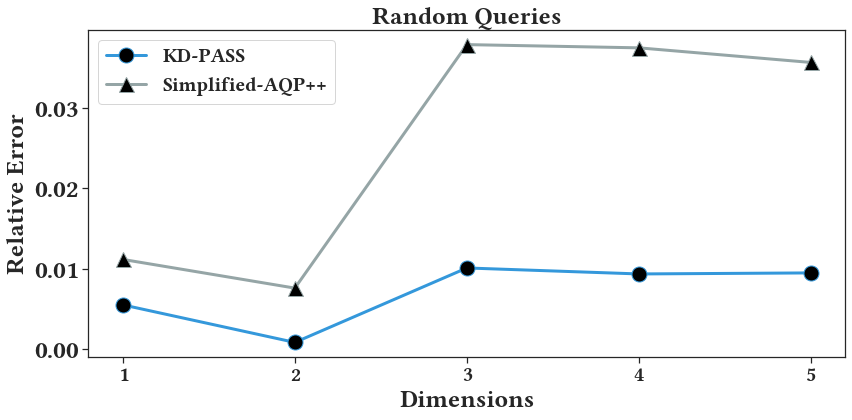

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


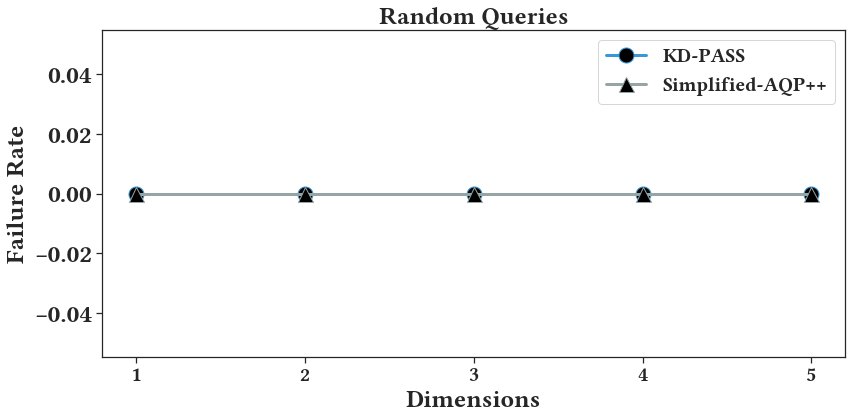

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


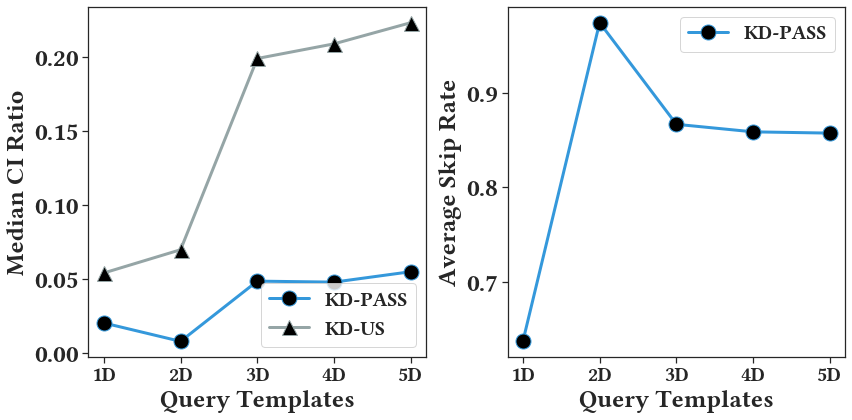

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [79]:
plot_percentile_1_columns({'Random Queries':random_analyzed}, log_scale=False, 
                          metric_id=0, percentiles=[50], show_avg=False, 
                          x_label = 'Dimensions', show_p = False, # y_label = 'Median Relative Error', 
                          fname='shift-RE')
plot_percentile_1_columns({'Random Queries':random_analyzed}, log_scale=False, 
                          metric_id=1, percentiles=[50], show_avg=False, 
                          x_label = 'Dimensions', show_p = False, # y_label = 'Median Relative Error', 
                          fname='shift-FR')
# plot_percentile_1_columns({'Random Queries':random_analyzed}, log_scale=False, 
#                           metric_id=4, percentiles=[50], show_avg=False, 
#                           x_label = 'Dimensions', show_p = False, # y_label = 'Median Relative Error', 
#                           fname='shift-SR')
plot_percentile_2_columns({'Random Queries':random_analyzed, 'Queries':random_analyzed}, log_scale=False, 
                          metric_ids=[3, 4], percentiles=[], show_avg=True, 
                          x_label = 'Query Templates', show_p = False, title=None,  y_labels=['Median CI Ratio', 'Average Skip Rate'],
                          fname='shift-CISR')


In [64]:
np.percentile(random_analyzed['5']['CI Ratio']['KDPASS'], 50)

0.03904578116640707

In [65]:
np.percentile(random_analyzed['5']['Skip Rate']['KDPASS'], 50)

0.9052734375

In [66]:
np.percentile(random_analyzed['2']['Skip Rate']['KDPASS'], 50)

0.978515625